# CS 316 : Introduction to Deep Learning - Fall 2024
## Lab 14 : Graph Neural Networks
### Dr. Abdul Samad

# Instructions

1. Make a copy of this notebook on google colab at start of the lab.

2. Please rename your notebook as *Lab_14_aa12345.ipynb* before starting the lab. Notebooks which do not follow appropriate naming convention will not be graded.

3. You have to submit this lab during the lab timings. You are allowed to submit till 11:59 PM on the day of your lab with a 30% penalty. No submissions will be accepted afterwards.

4. Use of AI is strictly prohibited. Anyone caught using Any AI tool during lab or while grading will be immediately reported to OCVS without any further discussion.

5. At the end of the lab, download the notebook (ipynb extension file) and upload it on canvas as a file. Submitting link to notebook or any other file will not be accepted.

6. Each task has points assigned to it. Total Lab is of 100 points.

7. Use of for loops is strictly prohibited.

8. For every theoretical question, there is a separate cell given at the end. You have to write your answer there.

9. If you have any questions, please feel free to reach out to the course instructor or RA.

# Task Overview: Graph Classification
##Introduction
In this tutorial we will use the The **MUTAG dataset** is a widely used benchmark dataset in graph classification, particularly in bioinformatics. Each graph in MUTAG represents a chemical compound, with nodes corresponding to atoms and edges to chemical bonds. The dataset is often used to test the performance of graph neural networks (GNNs) on classification tasks, where the aim is to classify each compound as either **mutagenic** or **non-mutagenic** based on its structure.

### Classes in the MUTAG Dataset

The MUTAG dataset has **two classes**:

1. **Class 0 (Non-Mutagenic)**: Compounds labeled as **non-mutagenic** do not induce mutations in specific organisms. These compounds are often considered safe from a biological or toxicological perspective in terms of mutagenic effects.

2. **Class 1 (Mutagenic)**: Compounds labeled as **mutagenic** are known to induce mutations in organisms. This mutagenic effect is an indicator of the compound’s potential to damage genetic material, which can lead to harmful biological consequences, including cancer. Therefore, detecting and classifying mutagenic compounds is critical for pharmaceutical and chemical industries.

In the context of graph classification, each graph (compound) is represented by a combination of nodes (atoms) and edges (chemical bonds) with labels indicating whether the compound is mutagenic or not.

### Details of Graph Structure in MUTAG

- **Nodes (Atoms)**: Each node in a graph represents an atom in a compound. Node features often encode information such as the type of atom (e.g., carbon, nitrogen, oxygen).
- **Edges (Bonds)**: Each edge represents a bond between two atoms. Bonds could be single, double, or aromatic, and they capture the connectivity within the compound.
  
### Purpose and Importance

The task of classifying MUTAG compounds into these two categories is important for assessing potential risks associated with chemical compounds and for drug discovery, where avoiding mutagenic effects is crucial. By training a GNN on this dataset, we aim to learn the structural patterns that differentiate mutagenic and non-mutagenic compounds based on atomic interactions and bond patterns.

Let's download a library we will use and then import other libraries


In [24]:
# Install required libraries (if not already installed)
!pip install torch torch-geometric matplotlib datasets


In [25]:
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

# [15 Points] Task 01 - Loading Dataset
# MUTAG Dataset details
We load the MUTAG dataset using [**TUDataset**](https://huggingface.co/datasets/glue) from **torch_geometric.datasets**. The dataset is automatically downloaded if not available. The dataset is then loaded into a form that torch_geometric can work with, where each graph has:

## Nodes (with features):
Each node may have associated features (e.g., the type of atom in chemical graphs).
##Edges:
Connections between nodes.
##Labels:
 For classification, each graph has a label indicating its class (for MUTAG, this could be mutagenic or non-mutagenic).

 For TUDataset root = 'data/MUTAG' and name = 'MUTAG'.

In [26]:
# Load the MUTAG dataset
#TODO
dataset = TUDataset(root='data/MUTAG', name='MUTAG')


#END TODO
# Display basic info about the dataset
print(f"Number of graphs: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of edge features: {dataset.num_edge_features}")

Number of graphs: 188
Number of classes: 2
Number of node features: 7
Number of edge features: 4


Output:

Number of graphs: 188

Number of classes: 2

Number of node features: 7

Number of edge features: 4

## MUTAG Dataset Instance

For MUTAG:
- Nodes (`data.x`) represent atoms (e.g., carbon, oxygen).
- Edges (`edge_index`) represent chemical bonds between atoms.
- Edge attributes (`edge_attr`) encode bond types (e.g., single, double, triple bonds).

This combination provides a rich representation of molecules as graphs!

In [27]:
data = dataset[1]
print(data)

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])




### Explaination of `Data.x`

- **Rows**: Each row in `data.x` corresponds to a **node** in the graph.
- **Columns**: Each column represents a specific **feature** of the node. These features could be categorical, numerical, or binary, depending on the dataset.

For the MUTAG dataset specifically:
-  Each graph represents a molecule, where:
  - Nodes represent **atoms** (e.g., carbon, oxygen, nitrogen).
  - Edges represent **bonds** between these atoms.



#### Decoding the Columns of `data.x`

1. **One-hot Encoding**:
   - Each column corresponds to a specific atom type (e.g., hydrogen, oxygen, carbon).
   - A value of `1` in a column indicates that the node belongs to that atom type; all other values in that row are `0`.

2. **Example**:
   Suppose the columns correspond to the following atom types:
   ```
   [Carbon (C), Oxygen (O), Nitrogen (N), Hydrogen (H), Fluorine (F), Chlorine (Cl), Bromine (Br)]
   ```
   A row `[1, 0, 0, 0, 0, 0, 0]` indicates a **Carbon** atom, while `[0, 1, 0, 0, 0, 0, 0]` indicates an **Oxygen** atom.

#### Meaning of Rows and Columns
- **Row**:
  A single row represents the features of one node (atom) in the graph (molecule).
- **Column**:
  Each column represents one feature, such as a specific atom type in this case.




In [28]:
# Access the first graph
data = dataset[0]

# Print node and edge features
print("\nFirst graph's node features:")
print(data.x)



First graph's node features:
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


###Explaination of `Data.edge_attr`
In the MUTAG dataset, `Data.edge_attr` encodes the **bond types** between atoms as features, such as single, double, triple, or aromatic bonds. For example, if `edge_attr = [[1, 0, 0, 0], [0, 1, 0, 0]]`, the first edge represents a single bond, and the second edge represents a double bond.

In [29]:

print("\nFirst graph's edge features (if any):")
if hasattr(data, 'edge_attr') and data.edge_attr is not None:
    print(data.edge_attr)
else:
    print("No edge features available.")


First graph's edge features (if any):
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],

In the MUTAG dataset (or any graph dataset in PyTorch Geometric), the `edge_index` represents the graph's **connectivity**—that is, how nodes are connected by edges.

### **Explanation of `Data.edge_index`**

1. **Definition**:
   - `edge_index` is a 2D tensor of shape `[2, num_edges]`.
   - It defines the connections (or edges) between nodes in the graph.
   - Each column in `edge_index` represents an edge, with two entries:
     - The first entry is the **source node**.
     - The second entry is the **target node**.

2. **Graph Representation**:
   - Graphs in PyTorch Geometric are represented in a **sparse adjacency matrix format** using `edge_index`.
   - Instead of storing a full adjacency matrix (which can be large and sparse), only the indices of connected nodes are stored.

3. **For Directed or Undirected Graphs**:
   - If the graph is **directed**, `edge_index` explicitly encodes the direction of each edge (e.g., `(i → j)`).
   - For an **undirected** graph (like MUTAG), each edge is stored in both directions: `(i → j)` and `(j → i)`.

---

### **Example**

Suppose `edge_index` looks like this:
```python
edge_index = [[0, 1, 1, 2],
              [1, 0, 2, 1]]
```

- The first row `[0, 1, 1, 2]` represents the **source nodes**.
- The second row `[1, 0, 2, 1]` represents the **target nodes**.
- This means there are the following edges:
  1. Node 0 → Node 1
  2. Node 1 → Node 0 (indicating an undirected edge between 0 and 1)
  3. Node 1 → Node 2
  4. Node 2 → Node 1 (indicating an undirected edge between 1 and 2)

---






In [30]:
# Print edge_index for the graph
print("Edge Index:")
print(data.edge_index)

# Loop through edges for better readability
print("\nEdges (source → target):")
for i in range(data.edge_index.shape[1]):
    src, tgt = data.edge_index[0, i], data.edge_index[1, i]
    print(f"{src.item()} → {tgt.item()}")

Edge Index:
tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])

Edges (source → target):
0 → 1
0 → 5
1 → 0
1 → 2
2 → 1
2 → 3
3 → 2
3 → 4
3 → 9
4 → 3
4 → 5
4 → 6
5 → 0
5 → 4
6 → 4
6 → 7
7 → 6
7 → 8
8 → 7
8 → 9
8 → 13
9 → 3
9 → 8
9 → 10
10 → 9
10 → 11
11 → 10
11 → 12
12 → 11
12 → 13
12 → 14
13 → 8
13 → 12
14 → 12
14 → 15
14 → 16
15 → 14
16 → 14



# [15 Points] Task 02 - Visualizing compound as a graph

Use [to_networkx](https://pytorch-geometric.readthedocs.io/en/2.5.3/modules/utils.html#torch_geometric.utils.to_networkx) method to convet it to a grah from visualization. You will pass the data to it as it is. please note that this is an Undirected Graph.

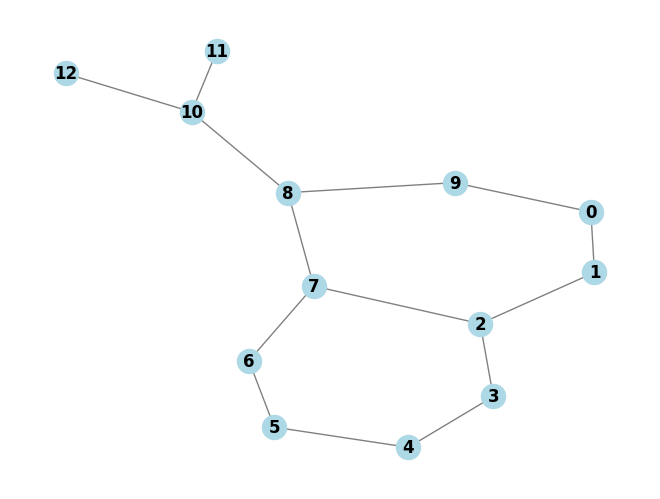

In [31]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Plot a sample graph from the dataset
def plot_graph(data):

    #TODO

    G = to_networkx(data, to_undirected=True)

    #END TODO
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')
    plt.show()

# Plot the first graph in the dataset
plot_graph(dataset[1])


Your graph should look like this:

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1kw75pJaZ8a4i-y9nptrb1-oYYp4kAFaz)
Figure: 1
</center>

# [15 Points] Task 03 - Converting into Adjacency Matrix for viusalization  

Use [to_dense_adj](https://pytorch-geometric.readthedocs.io/en/2.4.0/_modules/torch_geometric/utils/to_dense_adj.html) to convert the sample_graph into an adjacency matrix. sample_graph is a network object which has some attributes. Try printing it to see its attributes and then check what do you have to pass as parameters to to_dense_adj function (you will use edge index and max nodes paramters of the function for this task only. No need to pass the rest of the parameters). to_dense_adj function doesn't return a 2-dimensional tensor. Hence, you will need to extract a 2 dimensional tensor from it.

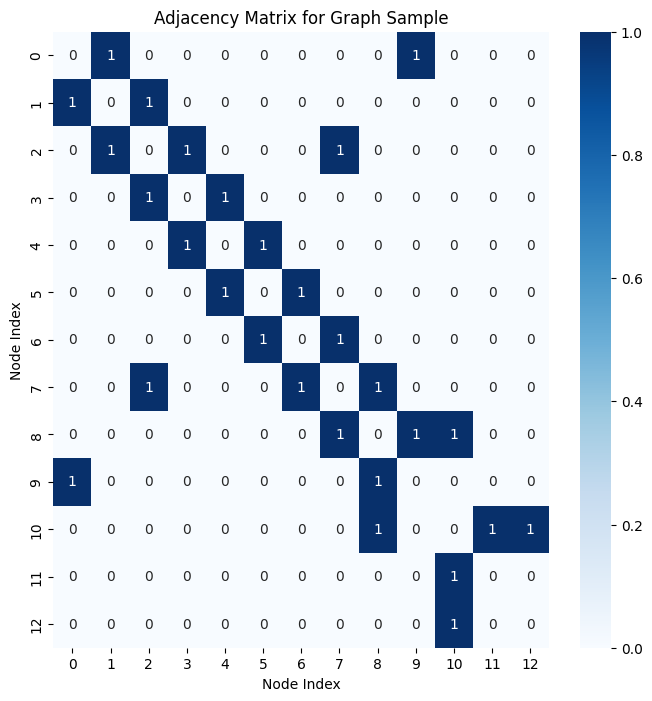

In [32]:
from torch_geometric.utils import to_dense_adj

# Select one graph sample from the dataset
sample_graph = dataset[1]

# Convert the edge index to a dense adjacency matrix
#TODO

adj_matrix = to_dense_adj(sample_graph.edge_index, max_num_nodes=sample_graph.num_nodes)[0]

#END TODO
# Convert the adjacency matrix tensor to a NumPy array for plotting
adj_matrix_np = adj_matrix.numpy()

# Plot the adjacency matrix using seaborn heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(adj_matrix_np, annot=True, fmt=".0f", cmap="Blues", cbar=True)
plt.title("Adjacency Matrix for Graph Sample")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()


Your Graph should look like this:

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1p0UeIrQ1setrhk1zCWQO-NgiTNk1ym1Z)
Figure: 1
</center>

# [15 Points] Task 04 - Splitting the data into train, test datasets

Using train_test_split function (already imported at start) split the dataset into train_dataset and test_dataset. Use test_size as 0.2 and random_state as 42

In [33]:
# Split dataset into training and testing sets
#TODO

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

#END TODO

# Display the size of each set
print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")


Number of training graphs: 150
Number of test graphs: 38


Output:

Number of training graphs: 150

Number of test graphs: 38

For graph-based models, we batch graphs together using DataLoader from torch_geometric. Batching helps in speeding up training by allowing multiple graphs to be processed in a single forward pass.

**train_loader:** Shuffles the training data, ensuring that each epoch sees the graphs in a different order.

**test_loader:** Doesn’t shuffle the test set, keeping it consistent across evaluations

In [34]:
# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# [25 Points] Task **05** - Define the GNN Model

`conv1` and `conv2` are [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/2.5.2/generated/torch_geometric.nn.conv.GCNConv.html) layers, each performing graph convolution operations (while going over this link, also look at the forward function given at the bottom of the page. That shows how to pass the data through it when using it in forward function). These layers learn the structural information by aggregating information from a node’s neighbors.

`conv1` takes node features (there is a parameter in your dataset for this and you have seen it printed at the start of the notebook as well)and maps them to a 64-dimensional space.

`conv2` takes these 64-dimensional embeddings and maps them to a new 64-dimensional space.

`fc` is a fully connected (linear) layer used to classify each graph after the convolution layers. Number of classes is also a paramter in your dataset.

Pass the parameters to GCNConv methods to construct the network and then a fully connected layer. Please note that there is no need of flattening operation in this network.

There are multiple TODOs in this function so complete all

In [35]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        #TODO
        self.conv1 = GCNConv(dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = nn.Linear(64, dataset.num_classes)
        #END TODO

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #TODO
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # global pooling
        x = self.fc(x)
        #END TODO
        output = F.log_softmax(x, dim=1)
        return output


In [36]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


Output:

GCN(

    (conv1): GCNConv(7, 64)

    (conv2): GCNConv(64, 64)

    (fc): Linear(in_features=64, out_features=2, bias=True)

)

The train function performs a single training epoch:


`out = model(data):` Performs a forward pass.

`loss = criterion(out, data.y):` Calculates the loss.
`loss.backward()` and `optimizer.step():` Updates model parameters.

# Train the GNN Model

In [37]:
# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate over batches
        data = data.to(torch.device("cpu"))
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Run training
epochs = 20
for epoch in range(1, epochs + 1):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')


Epoch 001, Loss: 0.6751
Epoch 002, Loss: 0.6200
Epoch 003, Loss: 0.6202
Epoch 004, Loss: 0.5900
Epoch 005, Loss: 0.5805
Epoch 006, Loss: 0.5781
Epoch 007, Loss: 0.5761
Epoch 008, Loss: 0.5395
Epoch 009, Loss: 0.5685
Epoch 010, Loss: 0.5433
Epoch 011, Loss: 0.5441
Epoch 012, Loss: 0.5456
Epoch 013, Loss: 0.5202
Epoch 014, Loss: 0.5582
Epoch 015, Loss: 0.5273
Epoch 016, Loss: 0.5681
Epoch 017, Loss: 0.5310
Epoch 018, Loss: 0.5383
Epoch 019, Loss: 0.5132
Epoch 020, Loss: 0.5146


# [15 Points] Task 06 - Evaluate the Model

pred variables contains predicted values of that batch and data.y contains correct values for that batch. Complete this function by first calculating the number of correct answers. Then divide the number of correct answers by len of data (you will need to figure out how to find length). Return the accuracy then.
Please note that the loop given below is running on a batch.

In [38]:
def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate over batches
        data = data.to(torch.device("cpu"))
        out = model(data)
        pred = out.argmax(dim=1)

        #TODO
        accuracy = (pred == data.y).sum().item() / len(data.y)


    #END TODO
    return accuracy

# Evaluate the model
train_acc = test(train_loader)
test_acc = test(test_loader)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')


Train Accuracy: 0.6667
Test Accuracy: 0.8333


You will get some accuracy here as output